### Disclaimer

The following notebook was compiled for the course 'Geostatistics' at Ghent University (lecturer-in-charge: Prof. Dr. Ellen Van De Vijver; teaching assistant: Pablo De Weerdt). It consists of notebook snippets created by Michael Pyrcz. The code and markdown (text) snippets were edited specifically for this course, using the 'Jura data set' (Goovaerts, 1997) as example in the practical classes. Some new code snippets are also included to cover topics which were not found in the Geostastpy package demo books.

This notebook is for educational purposes.<br> 

Guidelines for getting started were adapted from the 'Environmental Soil Sensing' course at Ghent University (lecturer-in-charge: Prof. Dr. Philippe De Smedt).<br> 

The Jura data set was taken from: Goovaerts P., 1997. Geostatistics for Natural Resources Evaluation. Oxford University Press.

**Don't forget to save a copy on your Google drive before starting**

You can also 'mount' your Google Drive in Google colab to directly access your Drive folders (e.g. to access data, previous notebooks etc.)

Do not hesitate to contact us for questions or feel free to ask questions during the practical sessions.

# Geostatistics: Introduction to geostatistical data analysis with Python

In [11]:
# Import required packages for setup
# -------------------------------------------- #

import sys
import os

In [12]:
# if you are not using Google Colab, change the path to the location of the repository
sys.path.append(r'c:\Users\pdweerdt\Documents\Repos\draft_E_I002454_Geostatistics')

In [13]:
#  Clone the repository and add it to the path
if 'google.colab' in sys.modules:
    !git clone https://github.com/SENSE-UGent/E_I002454_Geostatistics.git
    sys.path.append('/content/E_I002454_Geostatistics') #Default location in Google Colab after cloning
else:
    # if you are not using Google Colab, change the path to the location of the repository
    sys.path.append(r'c:\Users\pdweerdt\Documents\Repos\E_I002454_Geostatistics')

# Import the setup function
from Utils.setup import check_and_install_packages

# Read the requirements.txt file
if 'google.colab' in sys.modules:
    requirements_path = '/content/E_I002454_Geostatistics/Utils/requirements.txt'
else:
    requirements_path = 'c:/Users/pdweerdt/Documents/Repos/E_I002454_Geostatistics/Utils/requirements.txt'

with open(requirements_path) as f:
    required_packages = f.read().splitlines()

# Check and install packages
check_and_install_packages(required_packages)

#### Load Required libraries

In [14]:
import geostatspy
import geostatspy.GSLIB as GSLIB                              # GSLIB utilities, visualization and wrapper
import geostatspy.geostats as geostats                        # if this raises an error, you might have to check your numba isntallation   
print('GeostatsPy version: ' + str(geostatspy.__version__))   # these notebooks were tested with GeostatsPy version: 0.0.72

GeostatsPy version: 0.0.72


We will also need some standard packages. These should have been installed.

In [15]:
from tqdm import tqdm                                         # suppress the status bar
from functools import partialmethod

tqdm.__init__ = partialmethod(tqdm.__init__, disable=True)
                                   
import numpy as np                                            # ndarrays for gridded data
                                       
import pandas as pd                                           # DataFrames for tabular data

import matplotlib.pyplot as plt                               # for plotting

from scipy import stats                                       # summary statistics

plt.rc('axes', axisbelow=True)                                # plot all grids below the plot elements

ignore_warnings = True                                        # ignore warnings?
if ignore_warnings == True:                                   
    import warnings
    warnings.filterwarnings('ignore')

from IPython.utils import io                                  # mute output from simulation

seed = 42                                                     # random number seed

In [16]:
from ipywidgets import interactive                      # widgets and interactivity
from ipywidgets import widgets                            
from ipywidgets import Layout
from ipywidgets import Label
from ipywidgets import VBox, HBox

### Optional libraries

These are not required to run the given version of this practical exercise, but might be useful if you want to extend this notebook with more code.

In [17]:
#  import math library
import math

import cmath

In [18]:
from scipy.stats import pearsonr                              # Pearson product moment correlation
from scipy.stats import spearmanr                             # spearman rank correlation    
                                   
import seaborn as sns                                         # advanced plotting

import matplotlib as mpl                                        

from matplotlib.ticker import (MultipleLocator, AutoMinorLocator) # control of axes ticks
from matplotlib.colors import ListedColormap 
import matplotlib.ticker as mtick 
import matplotlib.gridspec as gridspec

### Set the Working Directory

Do this to simplify subsequent reads and writes (avoid including the full address each time). 

##### For use in Google Colab

Run the following cell if you automatically want to get the data from the repository and store it on your Google Colab drive

In [19]:
# change the working directory to the cloned repository

os.chdir('E_I002454_Geostatistics')

# get the current directory and store it as a variable

cd = os.getcwd()
print("Current Working Directory is " , cd)

FileNotFoundError: [WinError 2] The system cannot find the file specified: 'E_I002454_Geostatistics'

##### For local use

Only run the following cell if you have the data locally stored.

In [20]:
# set the working directory, place an r in front to address special characters
os.chdir(r'C:\\Users\\pdweerdt\\OneDrive - UGent\\I002454 - Geostatistics\\AY 2024-2025\\Practicals')

# get the current directory and store it as a variable

cd = os.getcwd()
print("Current Working Directory is " , cd)

Current Working Directory is  C:\Users\pdweerdt\OneDrive - UGent\I002454 - Geostatistics\AY 2024-2025\Practicals


### Loading Tabular & Gridded Data

Here's the section to load our data file into a Pandas' DataFrame object.

Let's load and visualize a grid also.

Check the datatype of your gridded data.

In this case it is actually also a .dat file, so we can use the same function to import it. The .grid extension was given to indicate that it is gridded data.

In [21]:
# Here you can adjust the relative Path to the data folder

data_path = cd + '/Hard_data' 

In [22]:
file_name = '//prediction.dat'

df = GSLIB.GSLIB2Dataframe(data_path + file_name) # read the data

df.head()

,Xloc,Yloc,Landuse,Rock,Cd,Co,Cr,Cu,Ni,Pb,Zn
0,2.386,3.077,3.0,3.0,1.740,9.32,38.32,25.72,21.32,77.36,92.56
1,2.544,1.972,2.0,2.0,1.335,10.00,40.20,24.76,29.72,77.88,73.56
2,2.807,3.347,2.0,3.0,1.610,10.60,47.00,8.88,21.40,30.80,64.80
3,4.308,1.933,3.0,2.0,2.150,11.92,43.52,22.70,29.72,56.40,90.00
4,4.383,1.081,3.0,5.0,1.565,16.32,38.52,34.32,26.20,66.40,88.40


### Define feature of interest

In [44]:
feature = 'Co'
unit = 'ppm'
dist_unit = 'km'

In [24]:
#  define a colormap

cmap = plt.cm.inferno                                         # color map inferno

cmap_rainb = plt.cm.turbo # similar to what is shown on the slides

# Directional experimental variograms

### Experimental Variograms

We can use the location maps to help determine good variogram calculation parameters. For example:

```p
tmin = -9999.; tmax = 9999.; 
lag_dist = 100.0; lag_tol = 50.0; nlag = 7; bandh = 9999.9; azi = azi; atol = 22.5
```
* **tmin**, **tmax** are trimming limits - set to have no impact, no need to filter the data
* **lag_dist**, **lag_tol** are the lag distance, lag tolerance - set based on the common data spacing and tolerance as 50% of lag distance to avoid overlapping or missing pairs
* **nlag** is number of lags -
* **bandh** is the horizontal band width - here set to have no effect
* **azi** is the azimuth -

In [25]:
tmin = -9999.9; tmax = 9999.9

First we need to derive the direction of maximum spatial continuity (= azimuth angle)

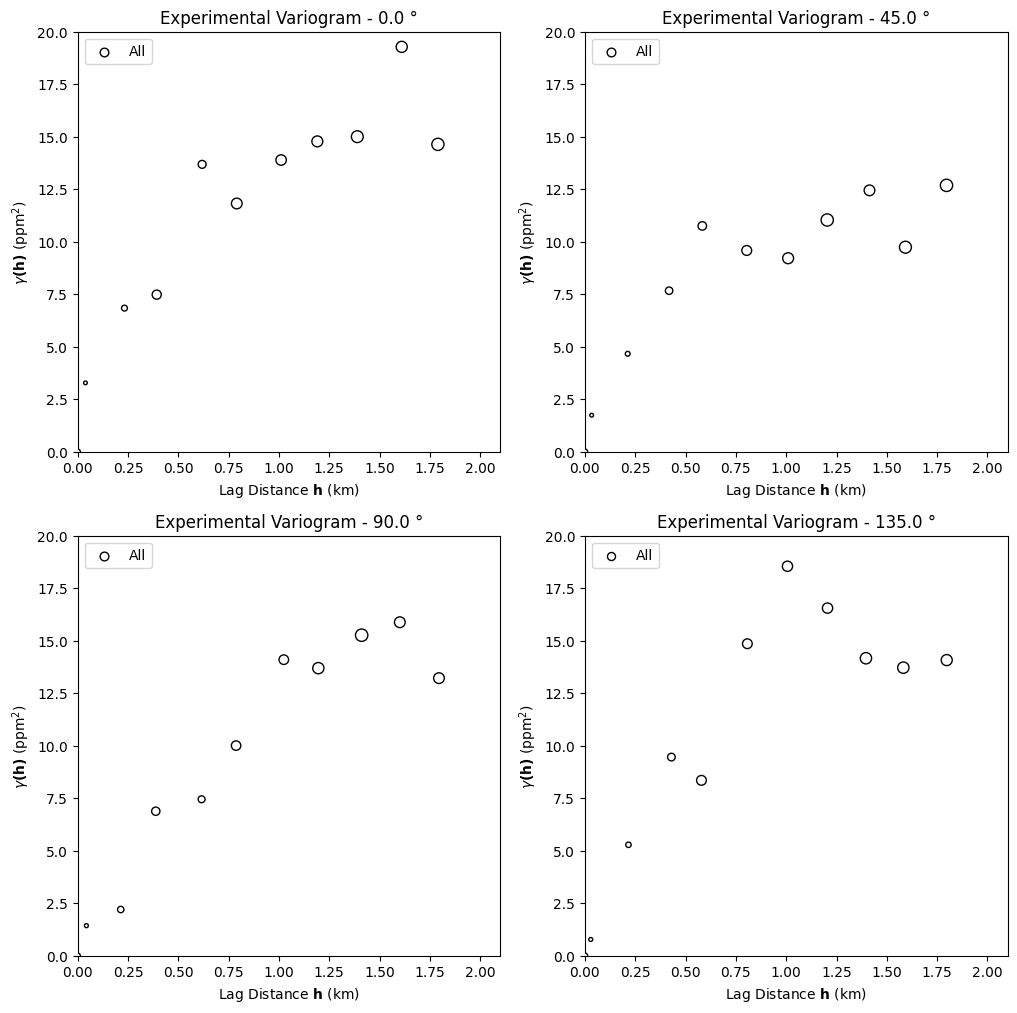

In [ ]:
# variogram parameters
lag_dist = 0.2
lag_tol = 0.1
nlag = 10
bandh = 9999.9

n_directions = 4 # directions will be equally divided
azi = 0 # value between 0 and 180, first direction to work around, 
        # can be first guess of azimuth angle

atol = 180/(n_directions*2) #preferably half of the angle separation
isill = None  # don't standardize sill

# Calculate variograms for four directions
plt.figure(figsize=(12, 12))

for direction in range(n_directions):
    # calculate the azimuth based on the initial azimuth and number of directions
    angle = (azi + direction * 180 / n_directions) % 180
    lag, gamma, npair = geostats.gamv(df, "Xloc", "Yloc", feature, 
                                    tmin, tmax, lag_dist, lag_tol, nlag, 
                                    angle, atol, bandh, isill
                                    )
    
    plt.subplot(2, 2, direction + 1)
    plt.scatter(lag, gamma, color='white', edgecolor='black', s=npair / 17, marker='o', label='All', zorder=10)
    
    plt.xlabel(r'Lag Distance $\bfh$ (' + dist_unit + ')')
    plt.ylabel(r'$\gamma \bf(h)$ (' + unit + '$^2$)')
    plt.title(f'Experimental Variogram - {angle} °')

    plt.xlim([0, 2.1]) # limit the maximum lag distance
    plt.ylim([0, 20])

    plt.legend(loc='upper left')

# Modelling directional experimental variograms



Fit a positive definite variogram model 
* **nug**: nugget effect

* **c1 / c2**: contributions of the sill - note

* **hmaj1 / hmaj2**: range in the major direction

* **hmin1 / hmin2**: range in the minor direction

What type of anisotropy did we observe?

## Geometrical anisotropy

In [ ]:
#  Geometrical anisotropy: the range varies as a function of the direction

nug = 0.2
nst = 1     #considering a model without nested structures                                    
it1 = 2     #structure: 1 - spherical, 2 - exponential, 3 - gaussian
cc1 = 0.64  #sill contribution
azi1 = 45  #Define the azimuth angle based on previous directional variograms
hmaj1 = 1.05; hmin1 = 0.35

vario_geom = GSLIB.make_variogram(
                                nug,nst,it1,cc1,azi1,hmaj1,hmin1,
                                ) # make model object

 make_variogram Warning: sill does not sum to 1.0, do not use in simulation 


 x,y,z offsets = 0.0,0.01
 x,y,z offsets = 0.007071067805519558,0.007071067818211393
 x,y,z offsets = 0.01,1.794896514920806e-11
 x,y,z offsets = 0.007071067830903228,-0.007071067792827723


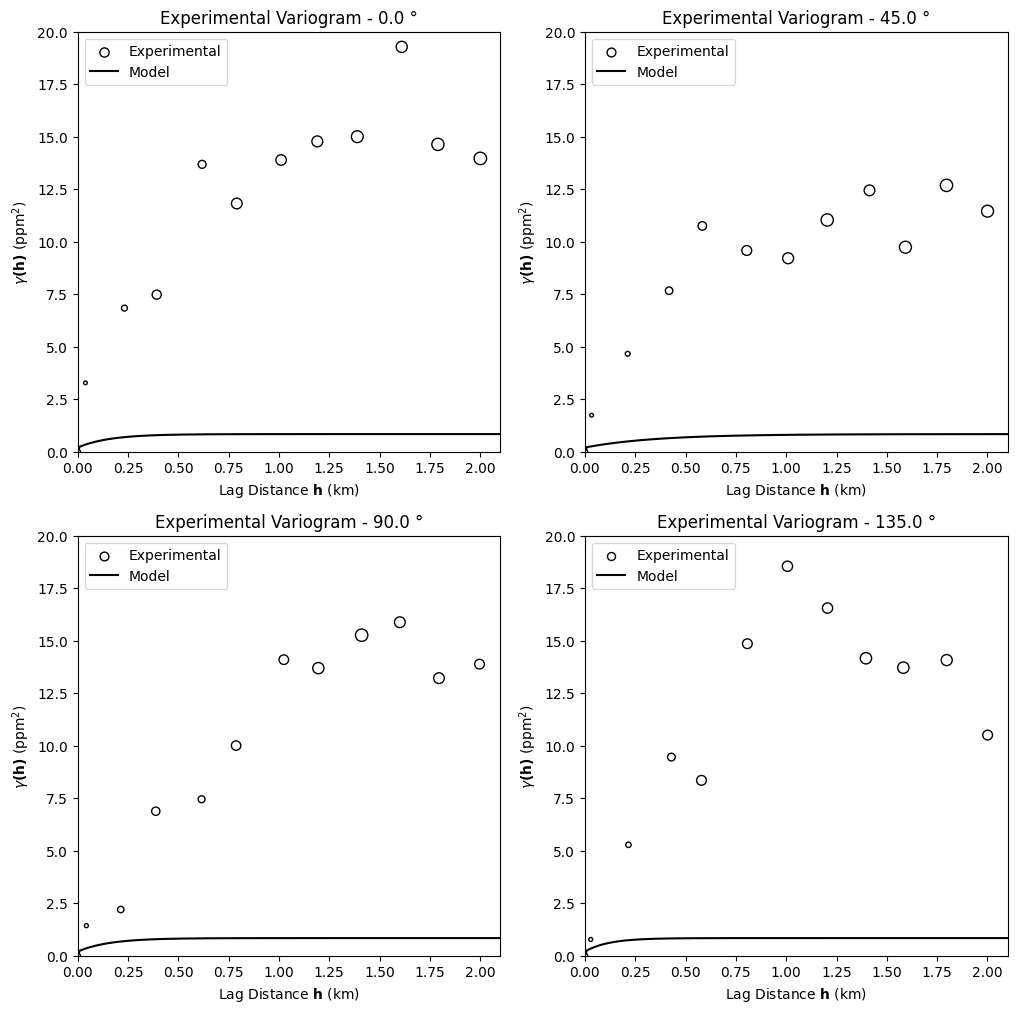

In [ ]:
# Calculate variograms for four directions
plt.figure(figsize=(12, 12))

# lags for the model function (not the same as the experimental variogram!)
xlag = 0.01; # set low value for model plotting,
nlag = 1000; # nlag times xlag should be greater than the maximum distance in the experimental variogram

for direction in range(n_directions):
    azi = 180 * direction / n_directions #e.g. for first direction, azi = 0
    lag, gamma, npair = geostats.gamv(df, "Xloc", "Yloc", feature, 
                                    tmin, tmax, lag_dist, lag_tol, nlag, 
                                    azi, atol, bandh, isill
                                    )
    
    index,h,gam,cov,ro = geostats.vmodel(nlag, xlag, azi, vario_geom
                                         )

    plt.subplot(2, 2, direction + 1)
    plt.scatter(lag, gamma, color='white', edgecolor='black', s=npair / 17, marker='o', label='Experimental', zorder=10)

    plt.plot(h,gam,color='black',
            #  lw=3,
            zorder=100,label = 'Model')

    plt.xlabel(r'Lag Distance $\bfh$ (' + dist_unit + ')')
    plt.ylabel(r'$\gamma \bf(h)$ (' + unit + '$^2$)')
    plt.title(f'Experimental Variogram - {azi} °')

    plt.xlim([0, 2.1])
    plt.ylim([0, 20])

    plt.legend(loc='upper left')

## Zonal Anisotropy

In [29]:
# Define the azimuth angle based on previous directional variograms
azi = 45

In [ ]:
nug = 1.45; nst = 2                                             # 2 nest structure variogram model parameters
it1 = 2; cc1 = 9.6; 
azi1 = 45; # can be any angle
hmaj1 = 1.1; hmin1 = 1.1
it2 = 2; # prefereably same as it1
cc2 = 4.2; # sill contribution of the second structure in major direction
azi2 = 45; # direction with maximum spatial continuity (perpendicular to the major axis)
hmaj2 = 1000; hmin2 = 1.1

vario_zon = GSLIB.make_variogram(nug,nst,it1,cc1,azi1,hmaj1,hmin1,it2,cc2,azi2,hmaj2,hmin2) # make model object

 make_variogram Warning: sill does not sum to 1.0, do not use in simulation 


 x,y,z offsets = 0.0,0.01
 x,y,z offsets = 0.007071067805519558,0.007071067818211393
 x,y,z offsets = 0.01,1.794896514920806e-11
 x,y,z offsets = 0.007071067830903228,-0.007071067792827723


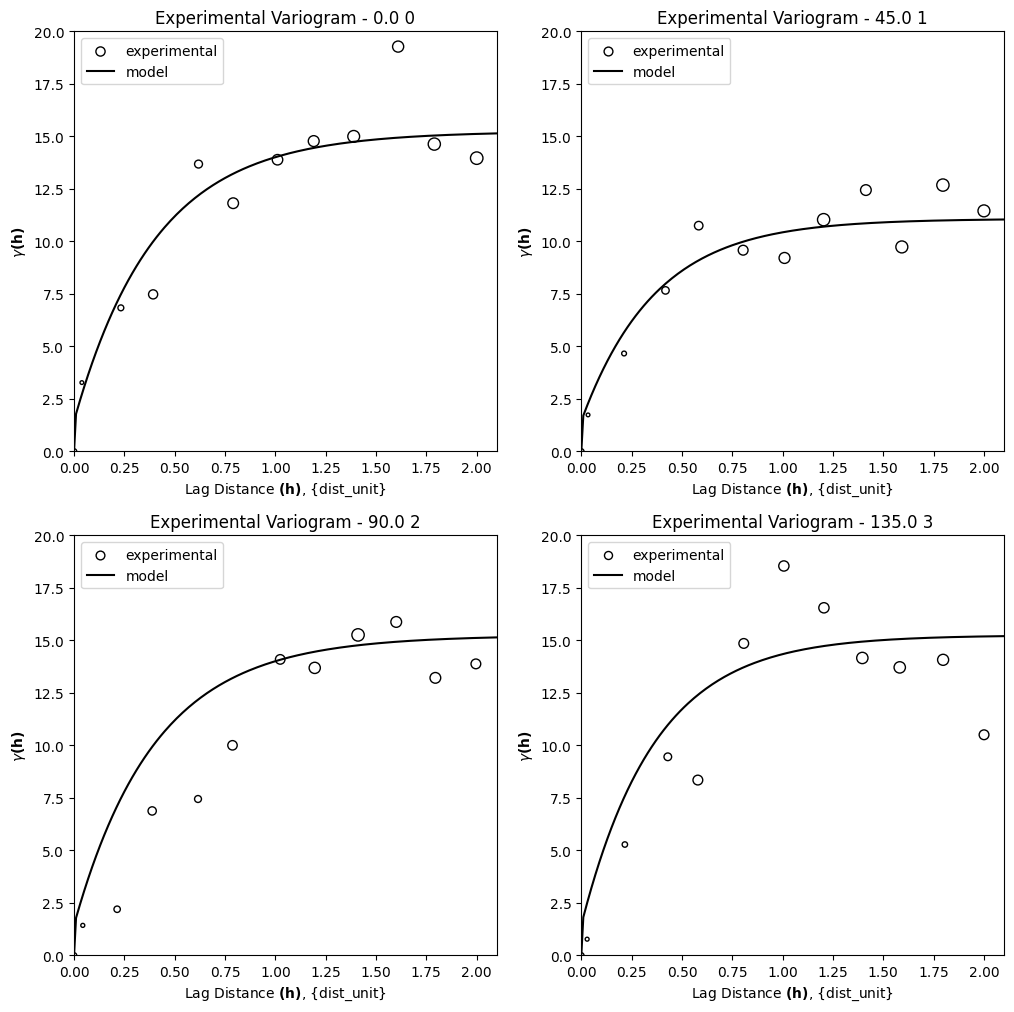

In [ ]:
# Calculate variograms for four directions
plt.figure(figsize=(12, 12))

# lags for the model function (not the same as the experimental variogram!)
xlag = 0.01; # set low value for model plotting,
nlag = 1000; # nlag times xlag should be greater than the maximum distance in the experimental variogram

for direction in range(n_directions):
    azi = 180 * direction / n_directions #e.g. for first direction, azi = 0
    lag, gamma, npair = geostats.gamv(df, "Xloc", "Yloc", feature, 
                                    tmin, tmax, lag_dist, lag_tol, nlag, 
                                    azi, atol, bandh, isill
                                    )
    
    index,h,gam,cov,ro = geostats.vmodel(nlag, xlag, azi, vario_zon
                                        )

    plt.subplot(2, 2, direction + 1)
    plt.scatter(lag, gamma, color='white', edgecolor='black', s=npair / 17, marker='o', label='experimental', zorder=10)
    plt.plot(h,gam,color='black',
            #  lw=3,
            zorder=100,label = 'model')

    plt.xlabel(r'Lag Distance $\bfh$ (' + dist_unit + ')')
    plt.ylabel(r'$\gamma \bf(h)$ (' + unit + '$^2$)')
    plt.title(f'Experimental Variogram - {azi} {direction}')

    plt.xlim([0, 2.1]) # limit the maximum lag distance
    plt.ylim([0, 20])

    plt.legend(loc='upper left')

# EXTRA CODE

Some extra code for interactive plotting, please note that this part is not fully worked out yet.

In [32]:
# from matplotlib import patches
# from math import sin, cos, radians, pi

In [33]:
# def vmodel_struct(nlag,xlag,azm,vario,istruct):
    
# # Parameters
#     MAXNST=4
#     DEG2RAD=3.14159265/180.0 
#     MAXROT=MAXNST+1
#     EPSLON = 1.0e-20
#     VERSION= 1.01

# # Declare arrays
#     index = np.zeros(nlag+1)
#     h = np.zeros(nlag+1)
#     gam = np.zeros(nlag+1)
#     cov = np.zeros(nlag+1)
#     ro = np.zeros(nlag+1)
    
# # Load the variogram
#     nst = vario["nst"]; cc = np.zeros(nst); aa = np.zeros(nst); it = np.zeros(nst); ang = np.zeros(nst)
#     anis = np.zeros(nst)
    
#     c0 = vario["nug"]
#     cc[0] = vario["cc1"]
#     it[0] = vario["it1"]
#     ang[0] = vario["azi1"]
#     aa[0] = vario["hmaj1"]
#     anis[0] = vario["hmin1"] / vario["hmaj1"]
#     if nst == 2:
#         cc[1] = vario["cc2"]
#         it[1] = vario["it2"]
#         ang[1] = vario["azi2"]
#         aa[1] = vario["hmaj2"]
#         anis[1] = vario["hmin2"] / vario["hmaj2"]
                    
#     xoff = math.sin(DEG2RAD*azm)*xlag
#     yoff = math.cos(DEG2RAD*azm)*xlag
#     print(' x,y,z offsets = ' + str(xoff) + ',' + str(yoff))
#     rotmat, maxcov = geostats.setup_rotmat(c0, nst, it, cc, ang, 99999.9)   
          
    
#     xx = 0.0; yy = 0.0      
#     for il in range(0,nlag+1):
#         index[il] = il
#         cov[il] = cova2_struct(0.0,0.0,xx,yy,nst,c0,9999.9,cc,aa,it,ang,anis,rotmat,maxcov,istruct)
#         #gam[il] = maxcov - cov[il]
#         if istruct == -1:
#             gam[il] = c0 - cov[il]  
#         else:
#             gam[il] = cc[istruct] - cov[il]
#         ro[il]  = cov[il]/maxcov
#         h[il]   = math.sqrt(max((xx*xx+yy*yy),0.0))
#         xx = xx + xoff
#         yy = yy + yoff

#     print(gam)
# # finished
#     return index,h,gam,cov,ro

# def cova2_struct(x1, y1, x2, y2, nst, c0, pmx, cc, aa, it, ang, anis, rotmat, maxcov, istruct):
#     EPSLON = 0.000001
#     # Check for very small distance
#     dx = x2 - x1
#     dy = y2 - y1

#     if (dx * dx + dy * dy) < EPSLON:
#         cova2_ = cc[istruct]
#         return cova2_
#     # Non-zero distance, loop over all the structures
#     cova2_ = 0.0
#     # Compute the appropriate structural distance 
#     dx1 = dx * rotmat[0, istruct] + dy * rotmat[1, istruct]
#     dy1 = (dx * rotmat[2, istruct] + dy * rotmat[3, istruct]) / anis[istruct]
#     h = math.sqrt(max((dx1 * dx1 + dy1 * dy1), 0.0))
#     if istruct == -1:
#         return 0.0
#     elif istruct == 0 or istruct == 1:
#         if it[istruct] == 1:# Spherical model
#             hr = h / aa[istruct]
#             if hr < 1.0:
#                 cova2_ = cova2_ + cc[istruct] * (1.0 - hr * (1.5 - 0.5 * hr * hr))
#         elif it[istruct] == 2: # Exponential model
#             cova2_ = cova2_ + cc[istruct] * np.exp(-3.0 * h / aa[istruct])
#         elif it[istruct] == 3: # Gaussian model
#             hh = -3.0 * (h * h) / (aa[istruct] * aa[istruct])
#             cova2_ = cova2_ + cc[istruct] * np.exp(hh)
#         elif it[istruct] == 4: # Power model
#             cov1 = pmx - cc[istruct] * (h ** aa[istruct])
#             cova2_ = cova2_ + cov1
#     return cova2_

# def point_pos(x0, y0, d, theta):
#     theta_rad = pi/2 - radians(theta)
#     return x0 + d*cos(theta_rad), y0 + d*sin(theta_rad)

In [34]:
# # interactive calculation of the experimental variogram
# l = widgets.Text(value='                              Variogram Calculation Interactive Demonstration, Michael Pyrcz, Associate Professor, The University of Texas at Austin',layout=Layout(width='950px', height='30px'))

# # set lag
# lag = widgets.FloatSlider(
#                         min = 0.1, max = 1, value = 0.1, step = 0.1, # optionally adjust the min, max and step size
#                         description = 'lag',orientation='vertical',layout=Layout(width='90px', height='200px'),
#                         continuous_update=False
#                         )
# lag.style.handle_color = 'gray'

# # set lag tolerance
# lag_tol = widgets.FloatSlider(
#                             min = 0.01, max = 1, value = 0.01, step = 0.01, # optionally adjust the min, max and step size
#                             description = 'lag tolerance',orientation='vertical',layout=Layout(width='90px', height='200px'),
#                             continuous_update=False
#                             )
# lag_tol.style.handle_color = 'gray'

# # set number of lags
# nlag = widgets.IntSlider(
#                         min = 1, max = 100, value = 1, step = 1, # optionally adjust the min, max and step size
#                         description = 'number of lags',orientation='vertical',layout=Layout(width='90px', height='200px'),
#                         continuous_update=False
#                         )
# nlag.style.handle_color = 'gray'

# # set azimuth
# azi = widgets.FloatSlider(
#                         min = 0, max = 360, value = 0, step = 5, # optionally adjust the min, max and step size
#                         description = 'azimuth',orientation='vertical',layout=Layout(width='90px', height='200px'),
#                         continuous_update=False
#                         )
# azi.style.handle_color = 'gray'

# # set azimuth tolerance
# azi_tol = widgets.FloatSlider(
#                             min = 10, max = 90, value = 90, step = 5, # optionally adjust the min, max and step size
#                             description = 'azimuth tolerance',orientation='vertical',layout=Layout(width='120px', height='200px'),
#                             continuous_update=False
#                             )
# azi_tol.style.handle_color = 'gray'

# # set bandwidth
# bandwidth = widgets.FloatSlider(
#                                 min = 0.1, max = 1000, value = 1000, step = 0.5, # optionally adjust the min, max and step size
#                                 description = 'bandwidth',orientation='vertical',layout=Layout(width='90px', height='200px'),
#                                 continuous_update=False
#                                 )
# bandwidth.style.handle_color = 'gray'

# ui1 = widgets.HBox([lag,lag_tol,nlag,azi,azi_tol,bandwidth],) # basic widget formatting    
# ui = widgets.VBox([l,ui1],)



In [35]:
# def f_make(lag,lag_tol,nlag,azi,azi_tol,bandwidth):     # function to take parameters, calculate variogram and plot
# #    text_trap = io.StringIO()
# #    sys.stdout = text_trap
#     global lags,gammas,npps,lags2,gammas2,npps2
#     tmin = -9999.9; tmax = 9999.9
#     lags, gammas, npps = geostats.gamv(
#                                     df,"Xloc","Yloc",feature,
#                                     tmin,tmax,lag,lag_tol,nlag,azi,azi_tol,bandwidth, isill=None
#                                     )
#     lags2, gammas2, npps2 = geostats.gamv(                                    
#                                     df,"Xloc","Yloc",feature,
#                                     tmin,tmax,lag,lag_tol,nlag,azi+90,azi_tol,bandwidth, isill=None
#                                     )
#     plt.subplot(111)                                    # plot experimental variogram
#     plt.scatter(lags,gammas,color = 'black',s = npps*0.03,label = 'Major Azimuth ' +str(azi), alpha = 0.8)
#     plt.scatter(lags2,gammas2,color = 'red',s = npps*0.03,label = 'Minor Azimuth ' +str(azi+90.0), alpha = 0.8)
#     # plt.plot([0,2000],[1.0,1.0],color = 'black')
#     plt.xlabel(r'Lag Distance $\bf(h)$, (m)')
#     plt.ylabel(r'$\gamma \bf(h)$')
#     if azi_tol < 90.0:
#         plt.title('Directional NSCORE ' + feature + ' Variogram - Azi. ' + str(np.round(azi,0)) + ', Azi. Tol.' + str(azi_tol))
#     else: 
#         plt.title('Omni Directional NSCORE ' + feature + ' Variogram ')
#     plt.xlim([0,5]); plt.ylim([0,1.8])
#     plt.legend(loc="lower right")
#     plt.grid(True)
    
#     plt.subplots_adjust(left=0.0, bottom=0.0, right=1.5, top=1.0, wspace=0.3, hspace=0.3)
#     plt.show()
    
#     return

In [36]:
# # connect the function to make the samples and plot to the widgets    
# interactive_plot = widgets.interactive_output(f_make, {'lag':lag,'lag_tol':lag_tol,'nlag':nlag,'azi':azi,'azi_tol':azi_tol,'bandwidth':bandwidth})
# interactive_plot.clear_output(wait = True)               # reduce flickering by delaying plot updating

In [37]:
# display(ui, interactive_plot)                           # display the interactive plot

### Interactive Variogram Calculation Demonstration

* calculate omnidirectional and direction experimental variograms 

#### Michael Pyrcz, Associate Professor, University of Texas at Austin 

##### [Twitter](https://twitter.com/geostatsguy) | [GitHub](https://github.com/GeostatsGuy) | [Website](http://michaelpyrcz.com) | [GoogleScholar](https://scholar.google.com/citations?user=QVZ20eQAAAAJ&hl=en&oi=ao) | [Book](https://www.amazon.com/Geostatistical-Reservoir-Modeling-Michael-Pyrcz/dp/0199731446) | [YouTube](https://www.youtube.com/channel/UCLqEr-xV-ceHdXXXrTId5ig)  | [LinkedIn](https://www.linkedin.com/in/michael-pyrcz-61a648a1) | [GeostatsPy](https://github.com/GeostatsGuy/GeostatsPy)

### The Problem

Calculate interpretable experimental variograms for sparse, irregularly-space spatial data. Note, size of the experimental point is scaled by the number of pairs.

* **azimuth** is the azimuth of the lag vector

* **azimuth tolerance** is the maximum allowable departure from the azimuth

* **unit lag distance** the size of the bins in lag distance

* **lag distance tolerance** - the allowable tolerance in lage distance

* **number of lags** - number of lags in the experimental variogram

* **bandwidth** - maximum departure from the lag vector

In [38]:
# # interactive calculation of the sample set (control of source parametric distribution and number of samples)
# l = widgets.Text(value='               Variogram Modeling, Visualize Nested Structures and Azimuth Interpolation, Michael Pyrcz, Professor, The University of Texas at Austin',layout=Layout(width='950px', height='30px'))
# nug = widgets.FloatSlider(min = 0.0001, max = 1.0, value = 0.0001, step = 0.1, description = r'$c_{nugget}$',orientation='vertical',layout=Layout(width='60px', height='200px'))
# nug.style.handle_color = 'gray'
# it1 = widgets.Dropdown(options=['Spherical', 'Exponential', 'Gaussian'],value='Spherical',
#     description=r'$Type_1$:',disabled=False,layout=Layout(width='200px', height='30px'))
# # c1 = widgets.FloatSlider(min=0.0001, max = 1.0, value = 0.2, description = r'$c_1$',orientation='vertical',layout=Layout(width='60px', height='200px'))
# # c1.style.handle_color = 'gray'
# hmaj1 = widgets.FloatSlider(min=0.01, max = 10000.0, value = 800.0, step = 25.0, description = r'$a_{1,maj}$',orientation='vertical',layout=Layout(width='60px', height='200px'))
# hmaj1.style.handle_color = 'black'
# hmin1 = widgets.FloatSlider(min = 0.01, max = 10000.0, value = 325.0, step = 25.0, description = r'$a_{1,min}$',orientation='vertical',layout=Layout(width='60px', height='200px'))
# hmin1.style.handle_color = 'red'

# it2 = widgets.Dropdown(options=['Spherical', 'Exponential', 'Gaussian'],value='Spherical',
#     description=r'$Type_2$:',disabled=False,layout=Layout(width='200px', height='30px'))
# c2 = widgets.FloatSlider(min=0.0001, max = 1.0, value = 0.0001, description = r'$c_2$',orientation='vertical',layout=Layout(width='60px', height='200px'))
# c2.style.handle_color = 'gray'
# hmaj2 = widgets.FloatSlider(min=0.01, max = 10000.0, value = 800.0, step = 25.0, description = r'$a_{2,maj}$',orientation='vertical',layout=Layout(width='60px', height='200px'))
# hmaj2.style.handle_color = 'black'
# hmin2 = widgets.FloatSlider(min = 0.01, max = 10000.0, value = 325.0, step = 25.0, description = r'$a_{2,min}$',orientation='vertical',layout=Layout(width='60px', height='200px'))
# hmin2.style.handle_color = 'red'
# new_azimuth = widgets.FloatSlider(min = 0.0, max = 360.0, value = 45.0, step = 5.0, description = r'$azi_{inter}$',orientation='vertical',layout=Layout(width='60px', height='200px'))
# new_azimuth.style.handle_color = 'purple'

# ui9 = widgets.HBox([nug,it1,hmaj1,hmin1,it2,c2,hmaj2,hmin2,new_azimuth],)                   # basic widget formatting   
# #ui2 = widgets.HBox([it2,c2,hmaj2,hmin2],)                   # basic widget formatting   
# ui10 = widgets.VBox([l,ui9],)

# def convert_type(it):
#     if it == 'Spherical': 
#         return 1
#     elif it == 'Exponential':
#         return 2
#     else: 
#         return 3

# def f_make2(nug,it1,hmaj1,hmin1,it2,c2,hmaj2,hmin2,new_azimuth):                       # function to take parameters, make sample and plot
#     azimuth = azi.value
#     c1 = 1.0 - nug - c2
#     it1 = convert_type(it1); it2 = convert_type(it2)
#     if c2 > 0.0:
#         nst = 2
#     else:
#         nst = 1
    
#     vario = GSLIB.make_variogram(nug,nst,it1,c1,0.0,hmaj1,hmin1,it2,c2,0.0,hmaj2,hmin2) # make model object
#     nlag = 100; xlag = 10;                                     
#     index_maj,h_maj,gam_maj,cov_maj,ro_maj = geostats.vmodel(nlag,xlag,0.0,vario)   # project the model in the major azimuth                                                  # project the model in the 135 azimuth
#     index_min,h_min,gam_min,cov_min,ro_min = geostats.vmodel(nlag,xlag,90.0,vario)
#     index_new,h_new,gam_new,cov_new,ro_new = geostats.vmodel(nlag,xlag,azimuth-new_azimuth,vario)
    
#     _,h_maj0,gam_maj0,_,_ = vmodel_struct(nlag,xlag,0.0,vario,-1) 
#     _,h_maj1,gam_maj1,_,_ = vmodel_struct(nlag,xlag,0.0,vario,0) 
#     _,h_maj2,gam_maj2,_,_ = vmodel_struct(nlag,xlag,0.0,vario,1) 
#     _,h_min0,gam_min0,_,_ = vmodel_struct(nlag,xlag,90.0,vario,-1) 
#     _,h_min1,gam_min1,_,_ = vmodel_struct(nlag,xlag,90.0,vario,0) 
#     _,h_min2,gam_min2,_,_ = vmodel_struct(nlag,xlag,90.0,vario,1) 
#     _,h_new0,gam_new0,_,_ = vmodel_struct(nlag,xlag,azimuth-new_azimuth,vario,-1) 
#     _,h_new1,gam_new1,_,_ = vmodel_struct(nlag,xlag,azimuth-new_azimuth,vario,0) 
#     _,h_new2,gam_new2,_,_ = vmodel_struct(nlag,xlag,azimuth-new_azimuth,vario,1) 
    
#     plt.subplot(221)                                    # plot experimental variogram
#     plt.scatter(lags,gammas,color = 'black',s = npps*0.03,label = 'Major Azimuth ' +str(azimuth), alpha = 0.8,zorder=10)
#     plt.plot(h_maj,gam_maj,color = 'black',lw=3,zorder=10)
#     if nug > 0.0001: 
#         plt.plot(h_maj0,gam_maj0,color = 'black',lw=1.5)
#         plt.fill_between(h_maj,gam_maj0,np.full(len(h_maj),0),color='grey',alpha=1.0,zorder=1,label = 'Nugget')
#     if c1 > 0.0001: 
#         plt.plot(h_maj,gam_maj1+gam_maj0,color = 'black',lw=1.5)
#         plt.fill_between(h_maj,gam_maj1+gam_maj0,gam_maj0,color='darkorange',alpha=1.0,zorder=1,label = 'Structure #1')
    
#     if c2 > 0.0001:   
#         plt.plot(h_maj,gam_maj2+gam_maj1+gam_maj0,color = 'black',lw=1.5)
#         plt.fill_between(h_maj,gam_maj2+gam_maj1+gam_maj0,gam_maj1+gam_maj0,color='deepskyblue',alpha=1.0,zorder=1,label='Structure #2')
    
#     plt.plot([0,2000],[1.0,1.0],color = 'black',ls='--')
#     plt.xlabel(r'Lag Distance $\bf(h)$, (m)'); plt.ylabel(r'$\gamma \bf(h)$')
#     if azi_tol.value < 90.0:
#         plt.title('Major Directional NSCORE ' + feature + ' Variogram - Azi. ' + str(azimuth))
#     else: 
#         plt.title('Omni Directional NSCORE ' + feature + ' Variogram ')

#     if c1 > 0.0001:
#         plt.vlines(hmaj1,0,1.8,color='black',lw=1.5); 
#         plt.annotate('Structure 1 Range',[hmaj1-30,1.3],rotation=90.0);
#     if c2 > 0.0001:
#         plt.vlines(hmaj2,0,1.8,color='black',lw=2.0)
#         plt.annotate('Structure 2 Range',[hmaj2-30,1.3],color='black',rotation=90.0)
#     plt.xlim([0,1000]); plt.ylim([0,1.8])
#     plt.legend(loc="upper left")
#     plt.grid(True)
    
#     plt.subplot(222)                                    # plot experimental variogram
#     plt.scatter(lags2,gammas2,color = 'red',s = npps*0.03,label = 'Minor Azimuth ' +str(azimuth+90.0), alpha = 0.8,zorder=10)
#     plt.plot(h_min,gam_min,color = 'red',lw=3)
#     if nug > 0.0001:
#         plt.plot(h_min0,gam_min0,color = 'red',lw=1.5)
#         plt.fill_between(h_min,gam_min0,np.full(len(h_maj),0),color='grey',alpha=1.0,zorder=1,label = 'Nugget')
#     if c1 > 0.0001:  
#         plt.plot(h_min,gam_min1+gam_min0,color = 'red',lw=1.5)
#         plt.fill_between(h_min,gam_min1+gam_min0,gam_min0,color='darkorange',alpha=1.0,zorder=1,label = 'Structure #1')
    
#     if c2 > 0.0001:   
#         plt.plot(h_min,gam_min2+gam_min1+gam_min0,color = 'red',lw=1.5)
#         plt.fill_between(h_min,gam_min2+gam_min1+gam_min0,gam_min1+gam_min0,color='deepskyblue',alpha=1.0,zorder=1,label='Structure #2')
    
#     plt.plot([0,2000],[1.0,1.0],color = 'black',ls='--')
#     plt.xlabel(r'Lag Distance $\bf(h)$, (m)')
#     plt.ylabel(r'$\gamma \bf(h)$')
#     if azi_tol.value < 90.0:
#         plt.title('Minor Directional NSCORE ' + feature + ' Variogram - Azi. ' + str(azimuth + 90.0))
#     else: 
#         plt.title('Omni Directional NSCORE ' + feature + ' Variogram ')
#     if c1 > 0.0001:      
#         plt.vlines(hmin1,0,1.8,color='red',lw=1.5)
#         plt.annotate('Structure 1 Range',[hmin1-30,1.3],color='red',rotation=90.0)
#     if c2 > 0.0001:  
#         plt.vlines(hmin2,0,1.8,color='red',lw=2.0)
#         plt.annotate('Structure 2 Range',[hmin2-30,1.3],color='red',rotation=90.0)
#     plt.xlim([0,1000]); plt.ylim([0,1.8])
#     plt.legend(loc="upper left")
#     plt.grid(True)
    
#     plt.subplot(223)                                    # plot experimental variogram
#     plt.plot(h_new,gam_new,color = 'purple',lw=3)
#     if nug > 0.0001:
#         plt.plot(h_new0,gam_new0,color = 'purple',lw=1.5)
#         plt.fill_between(h_new,gam_new0,np.full(len(h_maj),0),color='grey',alpha=1.0,zorder=1,label = 'Nugget')
#     if c1 > 0.0001:
#         plt.plot(h_new,gam_new1+gam_new0,color = 'purple',lw=1.5)
#         plt.fill_between(h_new,gam_new1+gam_new0,gam_new0,color='darkorange',alpha=1.0,zorder=1,label = 'Structure #1')
    
#     if c2 > 0.0001:   
#         plt.plot(h_new,gam_new2+gam_new1+gam_new0,color = 'purple',lw=1.5)
#         plt.fill_between(h_new,gam_new2+gam_new1+gam_new0,gam_new1+gam_new0,color='deepskyblue',alpha=1.0,zorder=1,label='Structure #2')
    
#     plt.plot([0,2000],[1.0,1.0],color = 'black',ls='--')
#     plt.xlabel(r'Lag Distance $\bf(h)$, (m)')
#     plt.ylabel(r'$\gamma \bf(h)$')
#     if azi_tol.value < 90.0:
#         plt.title('Interpolated ' + feature + ' Variogram - Azi. ' + str(new_azimuth))
#     else: 
#         plt.title('Omni Directional NSCORE ' + feature + ' Variogram ')
        
#     if c1 > 0.0001:
#         plt.vlines(hmaj1,0,1.8,color='black',lw=1.5); 

#     if c1 > 0.0001:      
#         plt.vlines(hmin1,0,1.8,color='red',lw=1.5)
        
#     if c2 > 0.0001:
#         plt.vlines(hmaj2,0,1.8,color='black',lw=1.5); 
  
#     if c2 > 0.0001:      
#         plt.vlines(hmin2,0,1.8,color='red',lw=1.5)
    
#     # plt.vlines(hmin1,0,1.8,color='black',lw=1.5); plt.vlines(hmin2,0,1.8,color='deepskyblue',lw=1.5)
#     # plt.annotate('Structure 1 Range',[hmin1-30,1.3],rotation=90.0); plt.annotate('Structure 2 Range',[hmin2-30,1.3],color='deepskyblue',rotation=90.0)
#     plt.xlim([0,1000]); plt.ylim([0,1.8])
#     plt.legend(loc="upper left")
#     plt.grid(True)
    
#     plt.subplot(224)
    
#     plt.xlim([-2000,2000]); plt.ylim([-2000,2000]); plt.xlabel('X offset (m)'); plt.ylabel('Y offset (m)')
#     plt.plot([-2000,2000],[0,0],color='grey',lw=3,zorder=1); plt.plot([0,0],[-2000,2000],color='grey',lw=3,zorder=1)
#     plt.grid(True); plt.title('2D Variogram Structures - Ranges and Geometric Anisotropy')
    
#     if c1 > 0.0001:
#         e1 = patches.Ellipse((0, 0), hmaj1*2, hmin1*2,angle=90-azimuth, linewidth=2, fill=True,facecolor='darkorange',edgecolor='black',alpha=1.0,zorder=4)
#         plt.gca().add_patch(e1)
    
#     if c2 > 0.0001:
#         e2 = patches.Ellipse((0, 0), hmaj2*2, hmin2*2,angle=90-azimuth, linewidth=2, fill=True,facecolor='deepskyblue',edgecolor='black',alpha=1.0,zorder=2)
#         plt.gca().add_patch(e2)
    
#     xarr,yarr = point_pos(0, 0, hmaj1, azimuth)
#     plt.plot([0,xarr],[0,yarr],color='black',zorder=13)
    
#     xarr2,yarr2 = point_pos(0, 0, hmaj2, azimuth)
#     plt.plot([0,xarr2],[0,yarr2],color='black',zorder=10)
#     plt.annotate('Major',[xarr2,yarr2],zorder=10)
    
#     xarr1,yarr1 = point_pos(0, 0, hmin1, azimuth+90.0)
#     plt.plot([0,xarr1],[0,yarr1],color='red',zorder=13)
    
#     xarr2,yarr2 = point_pos(0, 0, hmin2, azimuth+90.0)
#     plt.plot([0,xarr2],[0,yarr2],color='red',zorder=10)
#     plt.annotate('Minor',[xarr2,yarr2],zorder=10,color='red')
    
#     xarr_new,yarr_new = point_pos(0, 0, 1200, new_azimuth)
#     plt.plot([0,xarr_new],[0,yarr_new],color='purple',zorder=10,lw=3)
#     plt.annotate('Interpolated Azimuth',[xarr_new,yarr_new],color='purple',zorder=10)
    
#     plt.subplots_adjust(left=0.0, bottom=0.0, right=2.0, top=2.5, wspace=0.2, hspace=0.2)
#     plt.show()
    
# # connect the function to make the samples and plot to the widgets    
# interactive_plot2 = widgets.interactive_output(f_make2, {'nug':nug, 'it1':it1, 'hmaj1':hmaj1, 'hmin1':hmin1, 'it2':it2, 'c2':c2, 'hmaj2':hmaj2, 'hmin2':hmin2,'new_azimuth':new_azimuth})
# interactive_plot2.clear_output(wait = True)               # reduce flickering by delaying plot updating  

In [39]:
# display(ui10, interactive_plot2)                           # display the interactive plot